In [ ]:
!pip install ipympl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 508 kB 7.8 MB/s 
     |████████████████████████████████| 11.2 MB 41.4 MB/s 
     |████████████████████████████████| 944 kB 21.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
# Core
import numpy as np
import math
import pandas as pd
from tqdm import tqdm
import yaml
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly
import plotly.express as px

# Sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import calinski_harabasz_score as chs, davies_bouldin_score as dbs, silhouette_score as shs

from google.colab import output
output.enable_custom_widget_manager()

import warnings
warnings.filterwarnings("ignore")

from drive.MyDrive.Kaggle.Clustering_072022.src.functions import *

In [ ]:
# Custom colour palette
custom_colors = ["#068fb1","#6f1573","#a44f14","#36f25c","#01a481", "#0eedd6", "#e6a582"]
sns.set_palette(sns.color_palette(custom_colors))

In [ ]:
config = yaml.load(open('drive/MyDrive/Kaggle/Clustering_072022/src/config.YAML', 'rb'))

In [ ]:
data = pd.read_csv(config['path'] + 'src/data.csv', index_col='id')
data2 = pd.read_csv(config['path'] + 'src/data_removed.csv', index_col='id')
cat_feats = data2.columns[data2.dtypes=='int'].tolist()
num_feats = data2.columns[data2.dtypes=='float'].tolist()

cluster_range = range(config['cluster_lower_range'], config['cluster_upper_range'])

In [133]:
df = pd.DataFrame(PowerTransformer().fit_transform(data2), columns=data2.columns)
bmm = BayesianGaussianMixture(n_components=7, max_iter=300, n_init=3)
preds = bmm.fit_predict(df)

In [135]:
sub = pd.read_csv(config['path'] + 'submissions/sample_submission.csv', index_col='Id')
sub['Predicted'] = preds
sub.to_csv('pt_preds.csv', index='Id')

# Intro
PCA (principle component analysis) and KMeans are both methods of grouping/clustering data. Principle components are just eigenvector/value pairs whose vector is chosen by maximizing the variance through that dimension. The 'explained variance' of each vector is used to calculate an appropriate number of principle components to use. Kmeans uses an algorithm which minimizes the mean distance between data points and K number of 'centroids' to iteratively group the data. We then use the metric Inertia (sum of squares between data points and their clusters centroid) to determine K.

In [ ]:
# As per the EDA, robust scaler should take care of some outliers along with scaling and powertransformer should fix the skew
data_processed = pd.DataFrame(PowerTransformer().fit_transform(RobustScaler().fit_transform(data)), columns=data.columns)
dfs = pd.DataFrame(PowerTransformer().fit_transform(data), columns=data.columns)

# PCA

## 3D Scatter Plot

In [ ]:
# PCA Raw Data
pca = PCA(n_components=3)
components = pca.fit_transform(data)
pca_unprocessed = pd.DataFrame(components, columns=[f'PCA{i+1}' for i in range(3)])

# 3D scatterplot
fig = px.scatter_3d(
    components, x=0, y=1, z=2, opacity=1,
    title='PCA Plot in 3D Using Unprocessed Data',
    labels={'0': 'PC1', '1': 'PC2', '2': 'PC3'},
    width=800, height=600
)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Robust Scaled and Power Transformed
pca = PCA(n_components=3)
pca_processed = pd.DataFrame(pca.fit_transform(data_processed), columns=[f'PCA{i+1}' for i in range(3)])

# 3D scatterplot
fig = px.scatter_3d(
    components, x=0, y=1, z=2, opacity=1,
    title='PCA Plot in 3D Using Unprocessed Data',
    labels={'0': 'PC1', '1': 'PC2', '2': 'PC3'},
    width=800, height=600
)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Power Transformed
pca = PCA(n_components=3)
components = pca.fit_transform(dfs)
pca_PT = pd.DataFrame(components, columns=[f'PCA{i+1}' for i in range(3)])

# 3D scatterplot
fig = px.scatter_3d(
    components, x=0, y=1, z=2, opacity=1,
    title='PCA Plot in 3D Using Unprocessed Data',
    labels={'0': 'PC1', '1': 'PC2', '2': 'PC3'},
    width=800, height=600
)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

- Both are quite blob like, the processed data is void of outliers though.

## Explained Variance

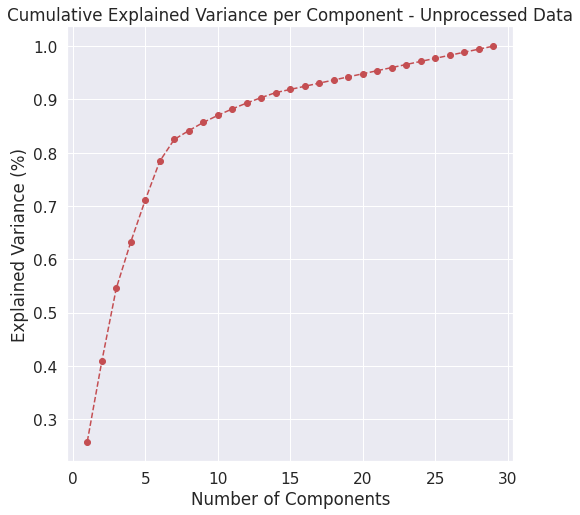

In [ ]:
# Unprocessed
pca_var = PCA()
pca_var = pca_var.fit(data)

plt.figure(figsize=(8, 8))
x = np.arange(1, 1+data.shape[1], step=1)
y = np.cumsum(pca_var.explained_variance_ratio_)
plt.plot(x, y, marker='o', linestyle='--', color='r')

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance (%)')
plt.title('Cumulative Explained Variance per Component - Unprocessed Data')
plt.savefig(config['path'] + 'src/images/PCA_explained_variance.png')
plt.show()

- 7 components looks right on the money 

# KMeans

In [ ]:
def score_kmeans(df, cluster_range):
    summ = pd.DataFrame()
    clusters = []
    inertias = []
    chs_scores = []
    db_scores = []
    sil_scores = []
    labels = []
    for cluster in tqdm(cluster_range):
        print(f'Cluster Number : {cluster}')
        kmeans = KMeans(n_clusters=cluster)
        kmeans.fit(df)
        clusters.append((cluster, kmeans.labels_))
        inertias.append(kmeans.inertia_)
        chs_scores.append(chs(df, kmeans.labels_))
        db_scores.append(dbs(df, kmeans.labels_))
        sil_scores.append(shs(df, kmeans.labels_))
        labels.append(kmeans.labels_)

    summ['clusters'] = cluster_range
    summ['inertias'] = inertias
    summ['chs_scores'] = chs_scores
    summ['db_scores'] = db_scores
    summ['sil_scores'] = sil_scores
    summ['labels'] = labels
    return clusters, summ

In [ ]:
def plot_scores(
        summary, 
        title, 
        filename, 
        metric1='davies_bouldin_score', 
        metric2='bic', 
        metric3='aic',
        metric1_label='Davies Bouldin Score', 
        metric2_label='BIC score', 
        metric3_label='AIC score',
        ):

    sns.set_style('white')
    plt.rcParams["figure.figsize"] = (20, 10)
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.75)

    twin1 = ax.twinx()
    twin2 = ax.twinx()

    # Offset the right spine of twin2.  The ticks and label have already been
    # placed on the right by twinx above.
    twin2.spines.right.set_position(("axes", 1.1))

    sns.lineplot(data=summary, x='clusters', y=metric1, ax=ax, color='r', label=metric1_label, linewidth=3)
    sns.lineplot(data=summary, x='clusters', y=metric2, ax=twin1, color='b', label=metric2_label, linewidth=3)
    sns.lineplot(data=summary, x='clusters', y=metric3, ax=twin2, color='g', label=metric3_label, linewidth=3)

    ax.set_xlabel("Clusters")
    ax.set_ylabel(metric1_label)
    twin1.set_ylabel(metric2_label)
    twin2.set_ylabel(metric3_label)

    ax.yaxis.label.set_color('r')
    twin1.yaxis.label.set_color('b')
    twin2.yaxis.label.set_color('g')

    tkw = dict(size=4, width=1.5)
    ax.tick_params(axis='y', colors='r', **tkw)
    twin1.tick_params(axis='y', colors='b', **tkw)
    twin2.tick_params(axis='y', colors='g', **tkw)
    ax.tick_params(axis='x', **tkw)

    ax.get_legend().remove()
    twin1.get_legend().remove()
    twin2.get_legend().remove()

    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

    plt.title(title)
    plt.savefig(config['path'] + 'src/images/' + filename)
    plt.show()

def plot_clusters(
                x,
                y,
                x_lab,
                y_lab,
                clusters_list,
                cluster_range,
                filepath,
                ncols=3,
                colorscale=None,
                title=None):
    
    nrows = math.ceil(len(cluster_range) / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))

    for cluster_list, ax in zip(clusters_list, axes.ravel()):
        ax.set_title(str(cluster_list[0])+" Clusters")
        ax.set_xlabel(x_lab)
        ax.set_ylabel(y_lab)
        sns.scatterplot(x=x, y=y, hue=cluster_list[1].astype(str), ax=ax, palette=sns.set_palette(sns.color_palette('Paired', len(cluster_range))))
        ax.legend(fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.suptitle(title)
    plt.savefig(config['path'] + 'src/images/' + filepath)
    plt.show()

## Raw Data

  0%|          | 0/8 [00:00<?, ?it/s]

Cluster Number : 4


 12%|█▎        | 1/8 [01:46<12:25, 106.49s/it]

Cluster Number : 5


 25%|██▌       | 2/8 [03:32<10:38, 106.45s/it]

Cluster Number : 6


 38%|███▊      | 3/8 [05:19<08:52, 106.43s/it]

Cluster Number : 7


 50%|█████     | 4/8 [07:04<07:03, 105.90s/it]

Cluster Number : 8


 62%|██████▎   | 5/8 [08:52<05:20, 106.81s/it]

Cluster Number : 9


 75%|███████▌  | 6/8 [10:40<03:34, 107.17s/it]

Cluster Number : 10


 88%|████████▊ | 7/8 [12:32<01:48, 108.60s/it]

Cluster Number : 11


100%|██████████| 8/8 [14:23<00:00, 107.98s/it]


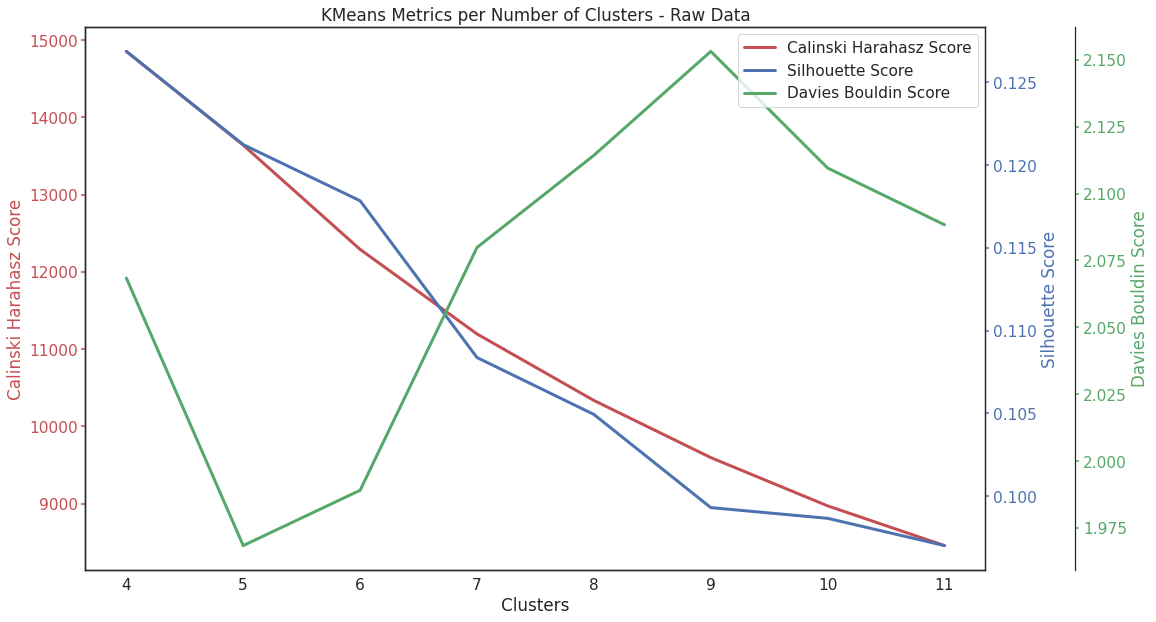

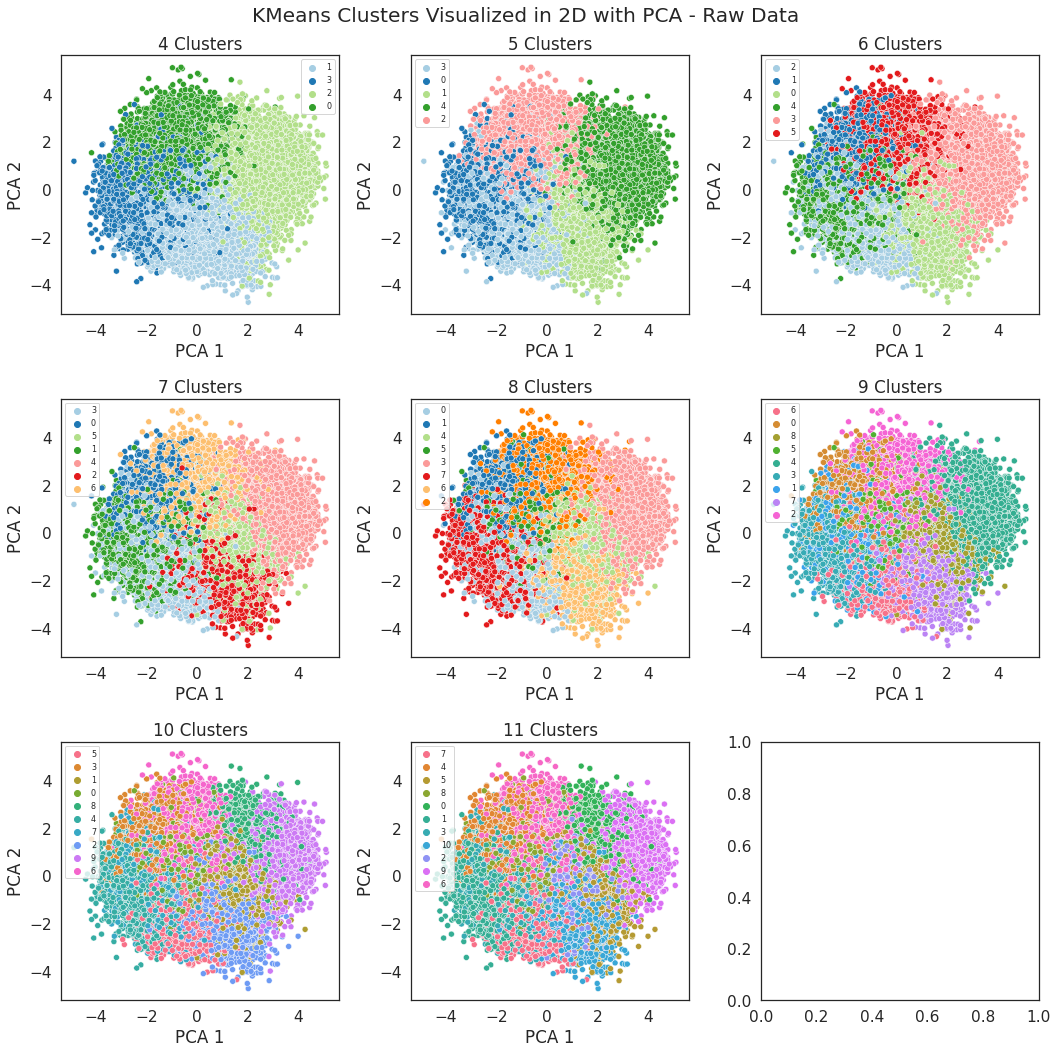

In [ ]:
clst_list, kmeans_summary = score_kmeans(data, cluster_range)

plot_scores(
    kmeans_summary,
    'KMeans Metrics per Number of Clusters - Raw Data',
     'KMeans_scores_raw.png',
     metric1='chs_scores',
     metric2='sil_scores',
     metric3='db_scores',
     metric1_label='Calinski Harahasz Score',
     metric2_label='Silhouette Score',
     metric3_label='Davies Bouldin Score')

plot_clusters(
    pca_PT['PCA1'], pca_PT['PCA2'], 
    'PCA 1', 'PCA 2', 
    clst_list, cluster_range, 
    'kmeans_clusters_raw.png', 
    title='KMeans Clusters Visualized in 2D with PCA - Raw Data ',
    ncols=3)

## Power Transformed Data

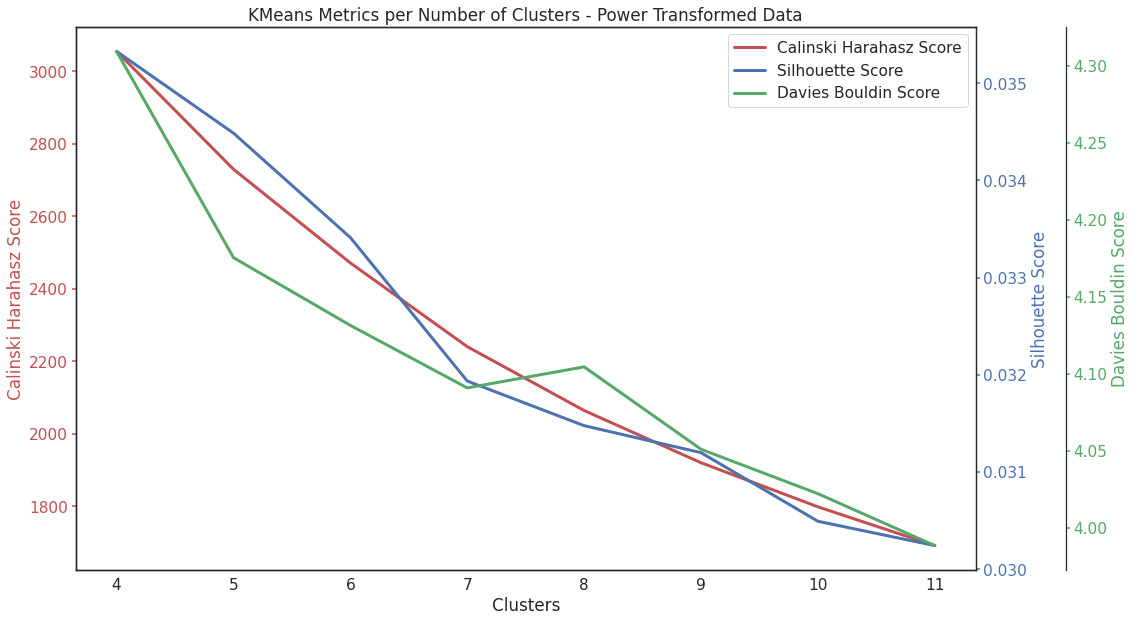

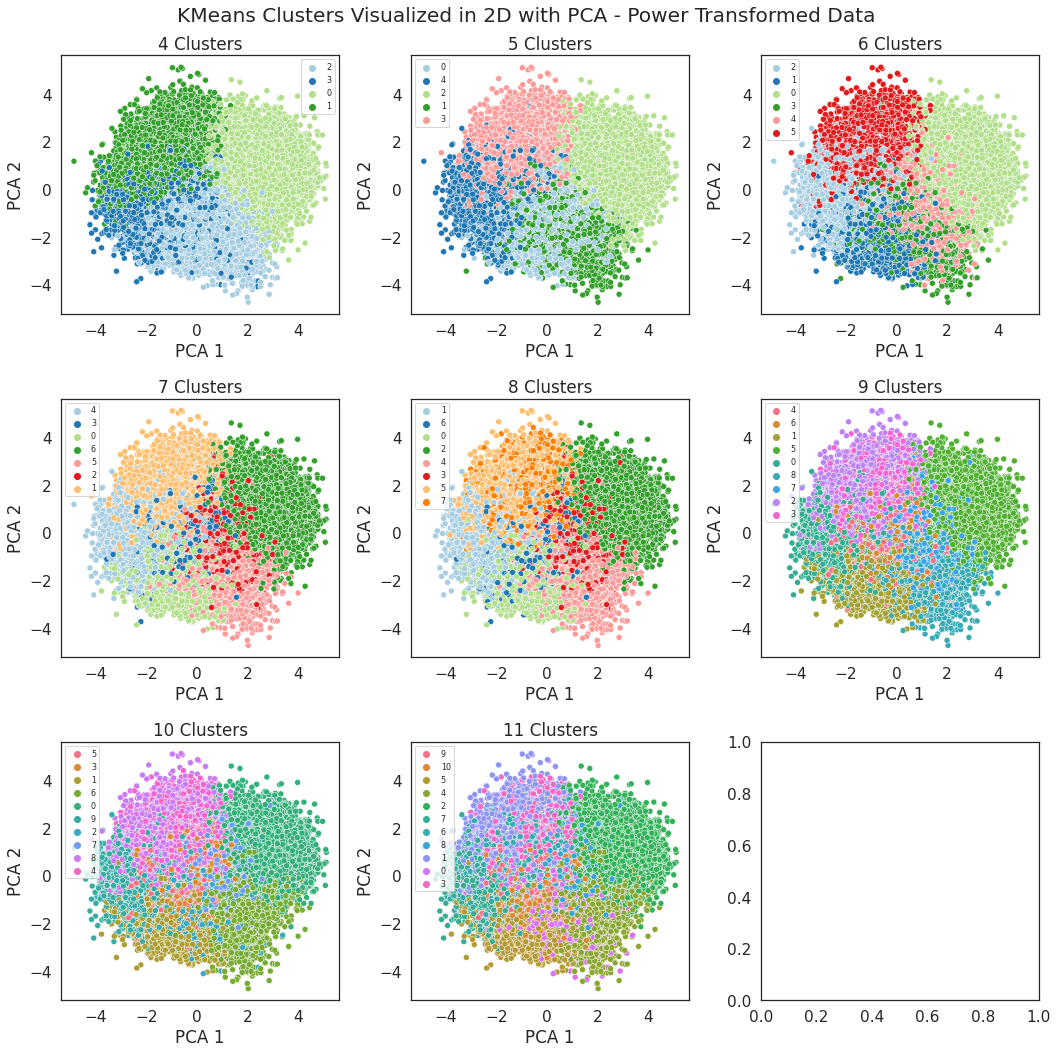

In [ ]:
# clst_list, kmeans_summary = score_kmeans(dfs, cluster_range)

plot_scores(
    kmeans_summary,
    'KMeans Metrics per Number of Clusters - Power Transformed Data',
     'KMeans_scores_PT.png',
     metric1='chs_scores',
     metric2='sil_scores',
     metric3='db_scores',
     metric1_label='Calinski Harahasz Score',
     metric2_label='Silhouette Score',
     metric3_label='Davies Bouldin Score')

plot_clusters(
    pca_PT['PCA1'], pca_PT['PCA2'], 
    'PCA 1', 'PCA 2', 
    clst_list, cluster_range, 
    'kmeans_clusters_PT.png', 
    title='KMeans Clusters Visualized in 2D with PCA - Power Transformed Data ',
    ncols=3)

## Power Transformed and Robust Scaled Data

  0%|          | 0/8 [00:00<?, ?it/s]

Cluster Number : 4


 12%|█▎        | 1/8 [01:48<12:37, 108.28s/it]

Cluster Number : 5


 25%|██▌       | 2/8 [03:38<10:57, 109.57s/it]

Cluster Number : 6


 38%|███▊      | 3/8 [05:29<09:11, 110.33s/it]

Cluster Number : 7


 50%|█████     | 4/8 [07:19<07:20, 110.05s/it]

Cluster Number : 8


 62%|██████▎   | 5/8 [09:11<05:32, 110.73s/it]

Cluster Number : 9


 75%|███████▌  | 6/8 [11:02<03:41, 110.91s/it]

Cluster Number : 10


 88%|████████▊ | 7/8 [12:55<01:51, 111.48s/it]

Cluster Number : 11


100%|██████████| 8/8 [14:49<00:00, 111.14s/it]


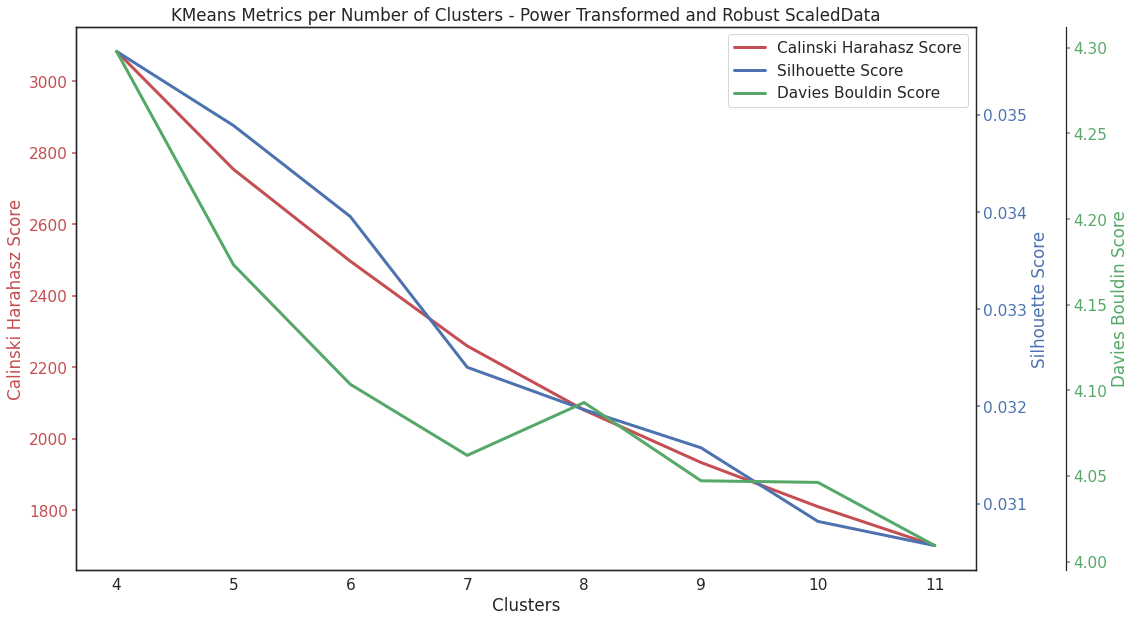

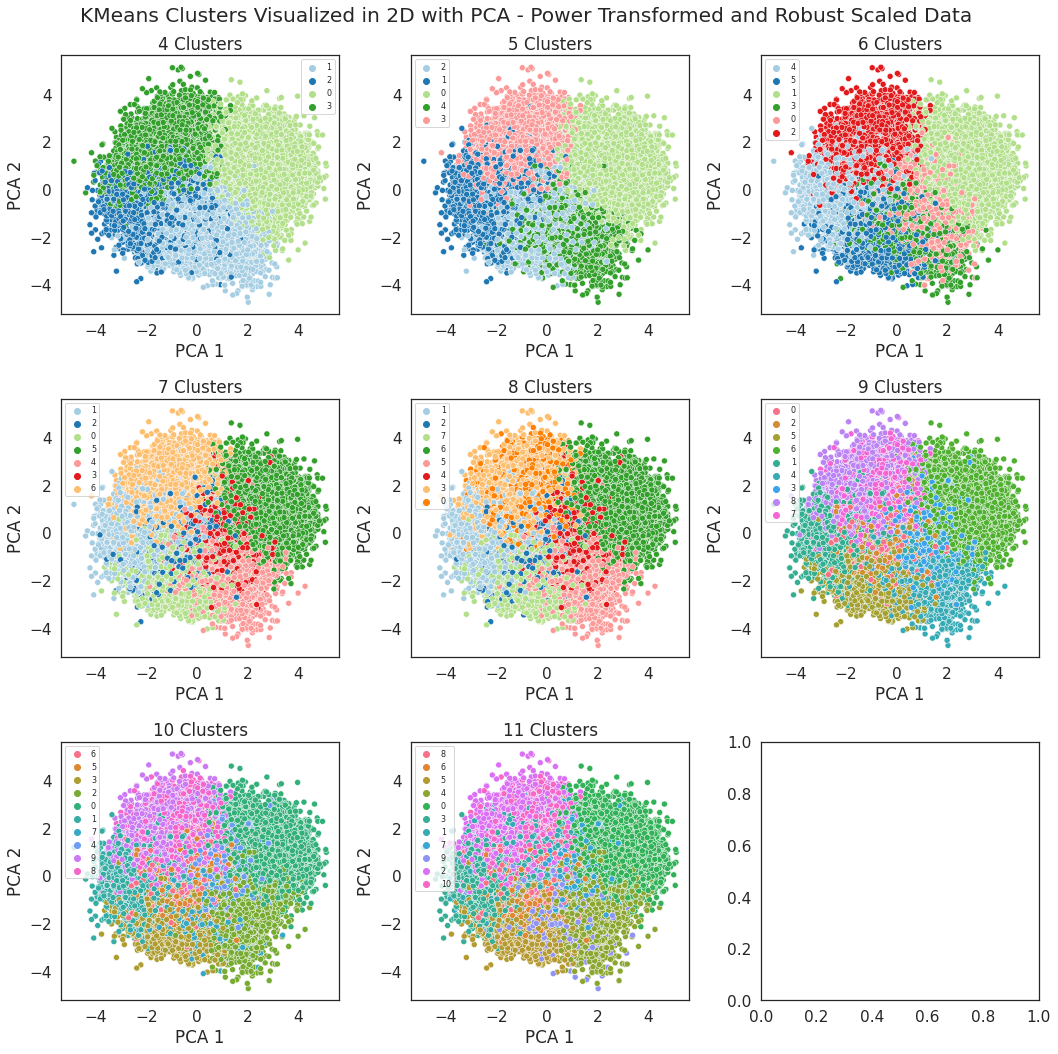

In [ ]:
clst_list, kmeans_summary = score_kmeans(data_processed, cluster_range)

plot_scores(
    kmeans_summary,
    'KMeans Metrics per Number of Clusters - Power Transformed and Robust ScaledData',
     'KMeans_scores_RSPT.png',
     metric1='chs_scores',
     metric2='sil_scores',
     metric3='db_scores',
     metric1_label='Calinski Harahasz Score',
     metric2_label='Silhouette Score',
     metric3_label='Davies Bouldin Score')

plot_clusters(
    pca_PT['PCA1'], pca_PT['PCA2'], 
    'PCA 1', 'PCA 2', 
    clst_list, cluster_range, 
    'kmeans_clusters_RSPT.png', 
    title='KMeans Clusters Visualized in 2D with PCA - Power Transformed and Robust Scaled Data ',
    ncols=3)

# Gaussian Mixture Model

In [ ]:
def score_gaussian(df, cluster_range):

    summary = pd.DataFrame()
    clusters = []
    bic = []
    aic = []
    convergence = []
    ch = []
    db = []
    labels = []

    for cluster in tqdm(cluster_range):
        gmm = GaussianMixture(n_components=cluster)
        gmm.fit(df)
        y_preds = gmm.predict(df)
        labels.append(y_preds)
        clusters.append((cluster, y_preds))
        ch.append(chs(df, y_preds))
        db.append(dbs(df, y_preds))
        convergence.append(gmm.converged_)
        bic.append(gmm.bic(df))
        aic.append(gmm.aic(df))

    summary["clusters"] = cluster_range
    summary["labels"] = labels
    summary["did_converge"] = convergence
    summary["calinski_harabasz_score"] = ch
    summary["davies_bouldin_score"] = db
    summary["aic"] = aic
    summary["bic"] = bic
    
    return clusters, summary

## Raw Data

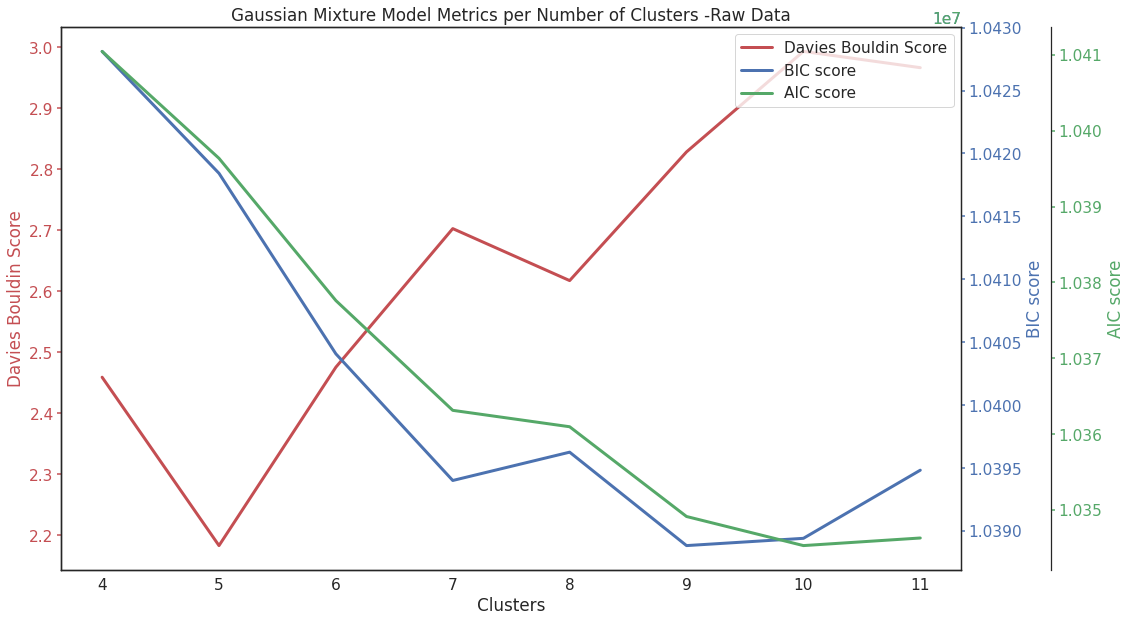

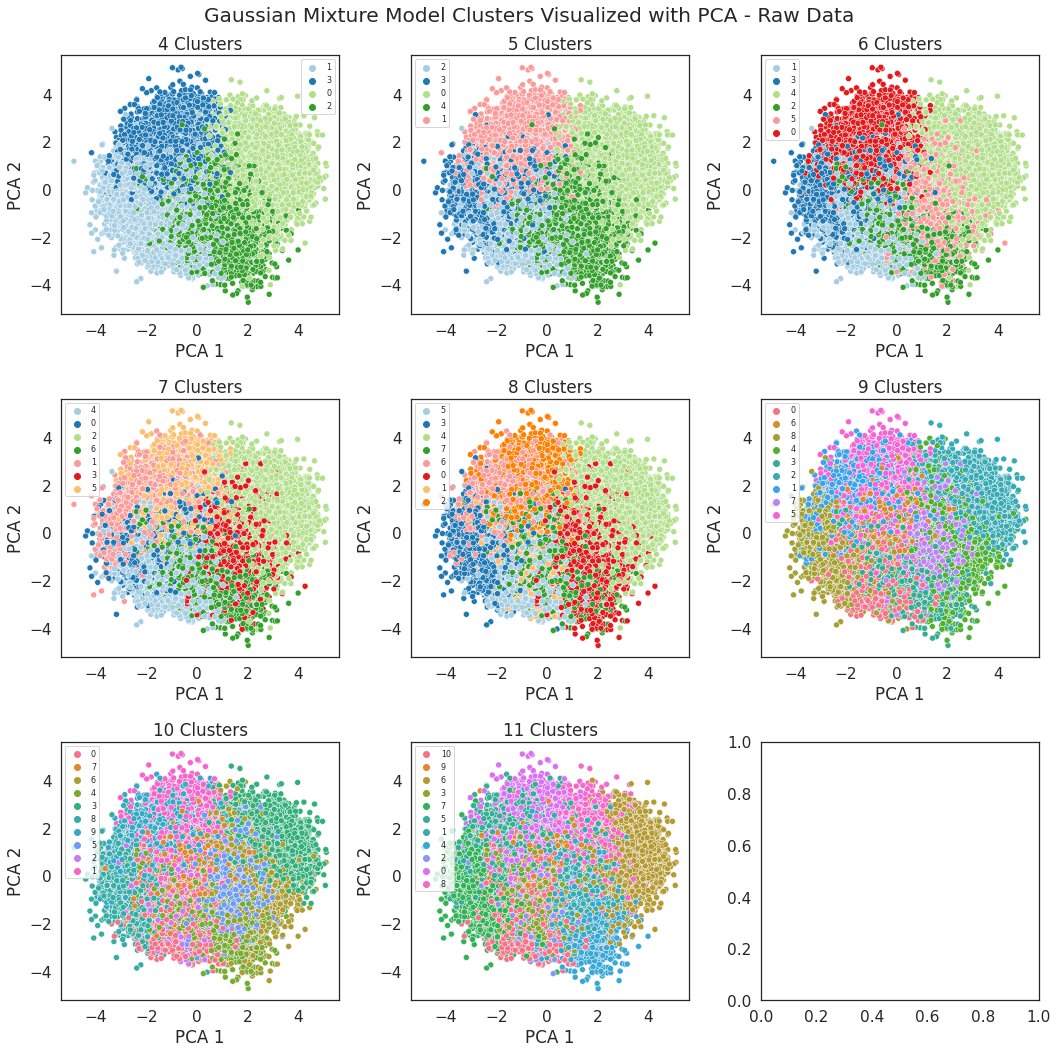

In [ ]:
gaussian_clusters, gaussian_summary = score_gaussian(data.to_numpy(), cluster_range)

plot_scores(
    gaussian_summary,
    'Gaussian Mixture Model Metrics per Number of Clusters -Raw Data',
    'gaussian_scores_raw.png'
    )

plot_clusters(
    pca_PT['PCA1'],
    pca_PT['PCA2'],
    'PCA 1', 'PCA 2',
    gaussian_clusters,
    cluster_range,
    'gaussian_clusters_raw.png',
    title='Gaussian Mixture Model Clusters Visualized with PCA - Raw Data',
    ncols=3
)

## Power Transformed

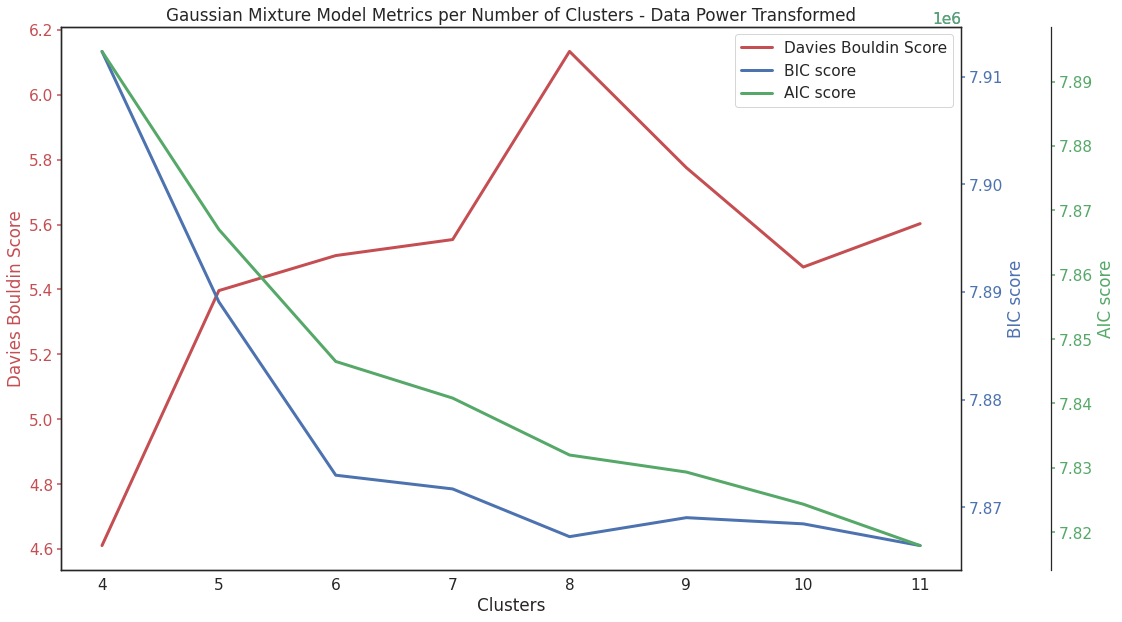

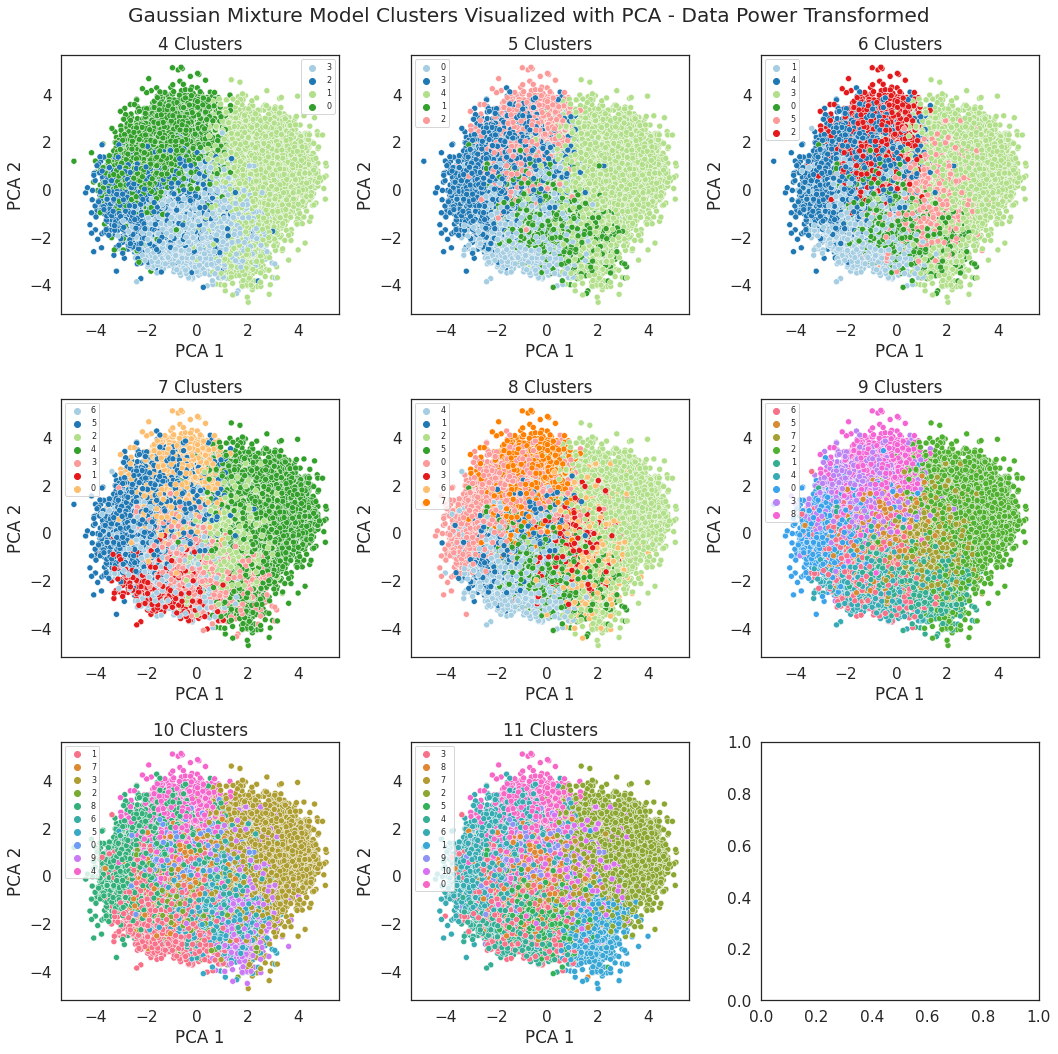

In [ ]:
gaussian_clusters, gaussian_summary = score_gaussian(dfs.to_numpy(), cluster_range)

plot_scores(
    gaussian_summary,
    'Gaussian Mixture Model Metrics per Number of Clusters - Data Power Transformed',
    'gaussian_scores_PT.png'
    )

plot_clusters(
    pca_PT['PCA1'],
    pca_PT['PCA2'],
    'PCA 1', 'PCA 2',
    gaussian_clusters,
    cluster_range,
    'gaussian_clusters_PT.png',
    title='Gaussian Mixture Model Clusters Visualized with PCA - Data Power Transformed',
    ncols=3
)

## Power Transformed and Robust Scaled

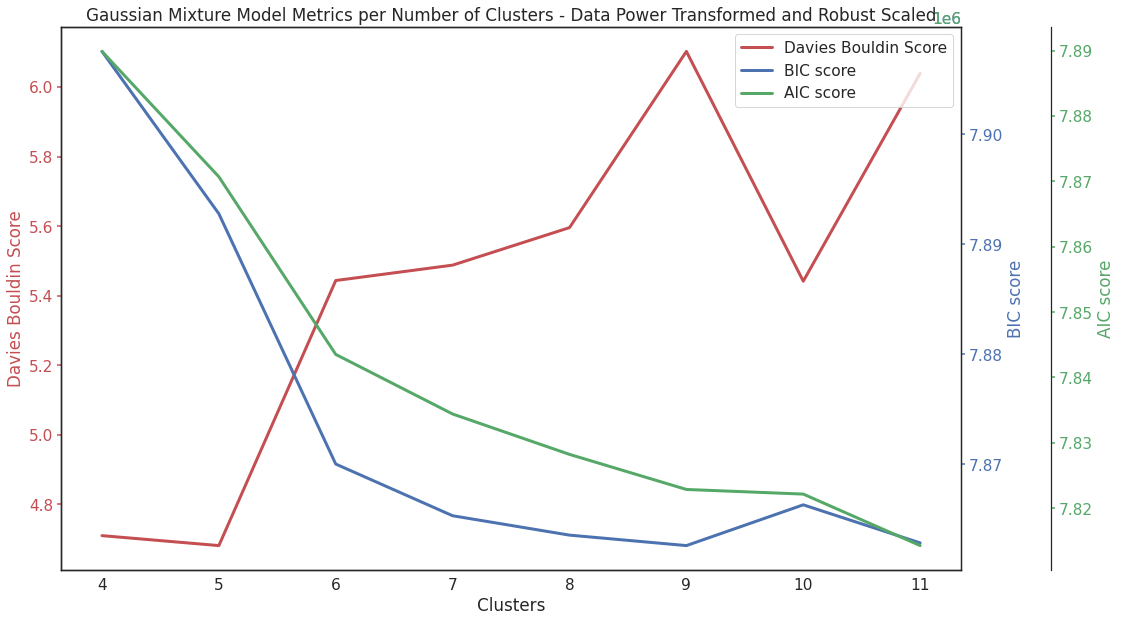

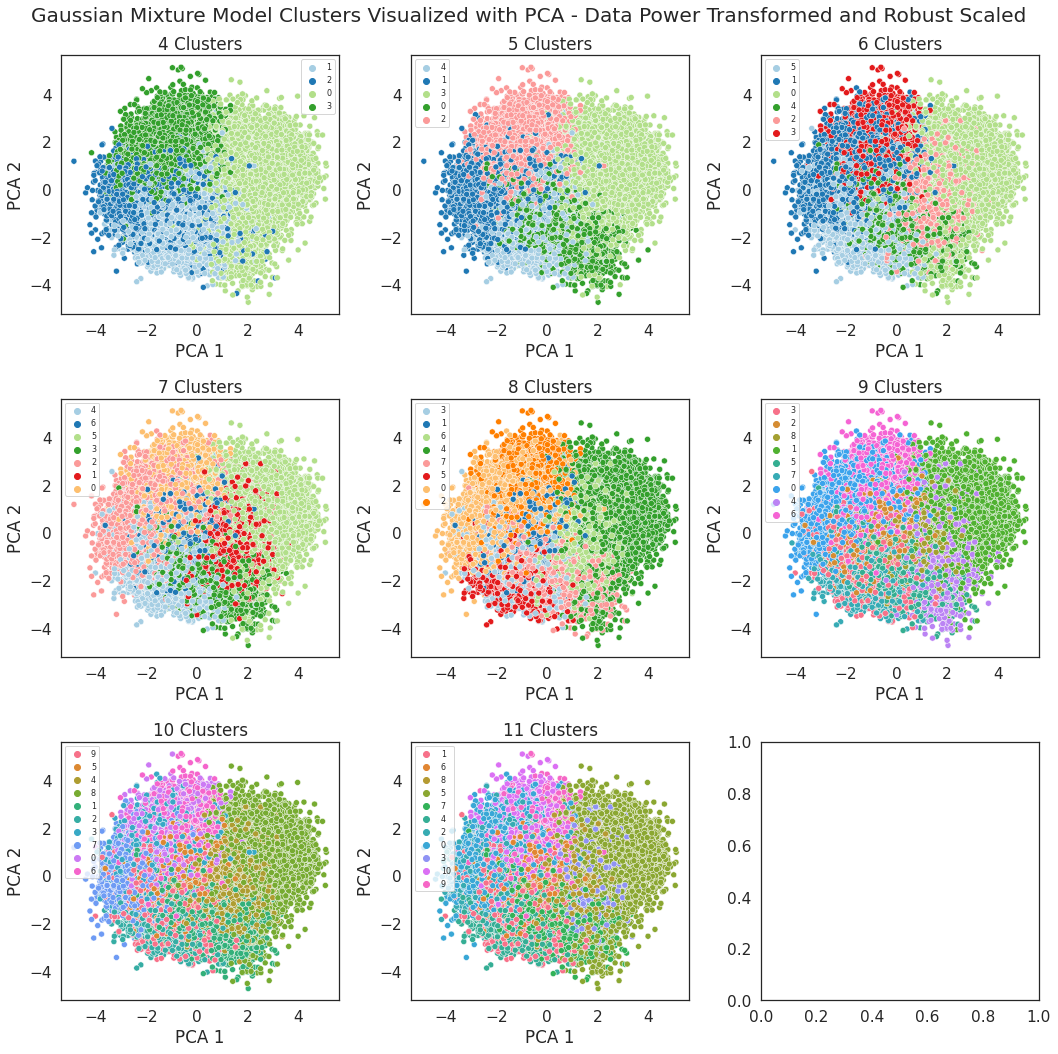

In [ ]:
gaussian_clusters, gaussian_summary = score_gaussian(data_processed.to_numpy(), cluster_range)

plot_scores(
    gaussian_summary,
    'Gaussian Mixture Model Metrics per Number of Clusters - Data Power Transformed and Robust Scaled',
    'gaussian_scores_RSPT.png'
    )

plot_clusters(
    pca_PT['PCA1'],
    pca_PT['PCA2'],
    'PCA 1', 'PCA 2',
    gaussian_clusters,
    cluster_range,
    'gaussian_clusters_RSPT.png',
    title='Gaussian Mixture Model Clusters Visualized with PCA - Data Power Transformed and Robust Scaled',
    ncols=3
)

In [ ]:
submissions = data.reset_index()['id']
kmeans = KMeans(7)
unprocessed_preds = kmeans.fit_predict(data)
processed_preds = kmeans.fit_predict(data_processed)
submissions['unprocessed_kmeans_7'] = unprocessed_preds
submissions['processed_kmeans_7'] = processed_preds